In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
pip install feature_engine

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import pandas_profiling
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve, classification_report

import joblib

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [69]:
df = pd.read_csv('/content/drive/MyDrive/Census/census.csv')
df.head()

age          workclass   fnlgt   education   education-num  \
0   39          State-gov   77516   Bachelors              13   
1   50   Self-emp-not-inc   83311   Bachelors              13   
2   38            Private  215646     HS-grad               9   
3   53            Private  234721        11th               7   
4   28            Private  338409   Bachelors              13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

    capital-gain   capital-loss   hours-per-week  native-country  salary  
0           2174              0               40   United-States   <=50K  
1              0              0               13   United-States   <=50K  
2              0              0               40   United-States   <=50K  
3              0              0               40   United-States   <=50K  
4              0              0               40            Cuba   <=50K

In [70]:
df.shape

(32561, 15)

In [75]:
# Eliminate space in columns
columns = [col.replace(' ', '') for col in list(df.columns)]
df.columns = columns

In [76]:
columns = [col.replace('-', '_') for col in list(df.columns)]
df.columns = columns

In [77]:
df.columns

Index(['age', 'workclass', 'fnlgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'salary'],
      dtype='object')

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlgt           32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [79]:
df.isnull().sum()

age               0
workclass         0
fnlgt             0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
salary            0
dtype: int64

In [12]:
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':False}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [80]:
def separate_cat_int_var(dataframe):
  categorical_features = []
  integer_features = []
  for var in list(dataframe.columns):
    if df[var].dtype == "int64":
      integer_features.append(var)
    else:
      categorical_features.append(var)
  
  return categorical_features, integer_features

In [81]:
y = df['salary']
X = df.drop('salary', axis=1)

In [82]:
categorical_features, integer_features = separate_cat_int_var(X)

In [83]:
categorical_features

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [84]:
for col in X[categorical_features].columns:
  print(col, ':' , len(X[col].unique()), 'labels')

workclass : 9 labels
education : 16 labels
marital_status : 7 labels
occupation : 15 labels
relationship : 6 labels
race : 5 labels
sex : 2 labels
native_country : 42 labels


In [85]:
integer_features

['age',
 'fnlgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

In [86]:
# Eliminate spaces in the columns values 
for var in categorical_features:
  X[var] = X[var].str.replace(" ", "")
  X[var] = X[var].str.replace("-", "_")

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

In [88]:
# standardisation: with the StandardScaler from sklearn

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train[integer_features])

# transform train and test sets
X_train_scaled = scaler.transform(X_train[integer_features])
X_test_scaled = scaler.transform(X_test[integer_features])

In [89]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=integer_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=integer_features)

In [90]:
X_train_scaled.head()

age     fnlgt  education_num  capital_gain  capital_loss  \
0 -0.334771 -1.261292      -0.423219     -0.146349      5.136118   
1  0.691223  0.510642      -0.035377      0.929742     -0.219921   
2 -1.140909 -1.261841      -0.035377     -0.146349     -0.219921   
3  1.277505  0.622115      -0.423219     -0.146349     -0.219921   
4 -1.580621  1.018212      -1.198902     -0.146349     -0.219921   

   hours_per_week  
0       -2.309851  
1       -0.031295  
2       -0.845065  
3       -0.031295  
4       -2.553982

In [91]:
X_test_scaled.head()

age     fnlgt  education_num  capital_gain  capital_loss  \
0 -0.847768 -0.279401      -0.035377     -0.146349     -0.219921   
1  0.471367 -1.317080      -0.423219     -0.146349     -0.219921   
2 -0.701197 -0.035817       1.128147     -0.146349     -0.219921   
3 -0.627912  0.003300       1.128147     -0.146349     -0.219921   
4 -0.701197 -0.003270      -0.035377      0.161865     -0.219921   

   hours_per_week  
0       -0.194049  
1       -0.031295  
2        1.189361  
3       -0.031295  
4        0.782475

In [92]:
# OneHotEncoding using Feature Engine

# set up the encoder
ohe_enc = OneHotEncoder(
    top_categories=None,
    variables=categorical_features,  # we can select which variables to encode
    drop_last=True)  # to return k-1, false to return k

# fit the encoder
ohe_enc.fit(X_train[categorical_features])

# transform the data
X_train_e = ohe_enc.transform(X_train[categorical_features])
X_test_e = ohe_enc.transform(X_test[categorical_features])



In [93]:
# Eliminate space in columns
columns = [col.replace(' ', '') for col in list(X_train_e.columns)]
columns = [col.replace('-', '_') for col in list(X_train_e.columns)]
X_train_e.columns = columns
X_test_e.columns = columns

In [94]:
X_train_e.head()

workclass_Self_emp_not_inc  workclass_State_gov  workclass_Local_gov  \
19749                           1                    0                    0   
1216                            1                    0                    0   
27962                           0                    1                    0   
23077                           0                    0                    1   
10180                           0                    0                    0   

       workclass_Private  workclass_Federal_gov  workclass_?  \
19749                  0                      0            0   
1216                   0                      0            0   
27962                  0                      0            0   
23077                  0                      0            0   
10180                  1                      0            0   

       workclass_Self_emp_inc  workclass_Without_pay  education_HS_grad  \
19749                       0                      0                  1   
1216                        0                      0                  0   
27962                       0                      0                  0   
23077                       0                      0                  1   
10180                       0                      0                  0   

       education_Some_college  ...  native_country_Cambodia  \
19749                       0  ...                        0   
1216                        1  ...                        0   
27962                       1  ...                        0   
23077                       0  ...                        0   
10180                       0  ...                        0   

       native_country_Outlying_US(Guam_USVI_etc)  native_country_Japan  \
19749                                          0                     0   
1216                                           0                     0   
27962                                          0                     0   
23077                                          0                     0   
10180                                          0                     0   

       native_country_Hong  native_country_Trinadad&Tobago  \
19749                    0                               0   
1216                     0                               0   
27962                    0                               0   
23077                    0                               0   
10180                    0                               0   

       native_country_Hungary  native_country_Honduras  native_country_Iran  \
19749                       0                        0                    0   
1216                        0                        0                    0   
27962                       0                        0                    0   
23077                       0                        0                    0   
10180                       0                        0                    0   

       native_country_Laos  native_country_Holand_Netherlands  
19749                    0                                  0  
1216                     0                                  0  
27962                    0                                  0  
23077                    0                                  0  
10180                    0                                  0  

[5 rows x 94 columns]

In [95]:
X_test_e.head(10)

workclass_Self_emp_not_inc  workclass_State_gov  workclass_Local_gov  \
14160                           0                    0                    0   
27048                           0                    1                    0   
28868                           0                    0                    0   
5667                            0                    0                    0   
7827                            1                    0                    0   
15382                           0                    0                    0   
4641                            1                    0                    0   
8943                            0                    0                    0   
216                             0                    0                    0   
5121                            0                    0                    0   

       workclass_Private  workclass_Federal_gov  workclass_?  \
14160                  1                      0            0   
27048                  0                      0            0   
28868                  1                      0            0   
5667                   1                      0            0   
7827                   0                      0            0   
15382                  1                      0            0   
4641                   0                      0            0   
8943                   1                      0            0   
216                    1                      0            0   
5121                   1                      0            0   

       workclass_Self_emp_inc  workclass_Without_pay  education_HS_grad  \
14160                       0                      0                  0   
27048                       0                      0                  1   
28868                       0                      0                  0   
5667                        0                      0                  0   
7827                        0                      0                  0   
15382                       0                      0                  0   
4641                        0                      0                  1   
8943                        0                      0                  1   
216                         0                      0                  0   
5121                        0                      0                  1   

       education_Some_college  ...  native_country_Cambodia  \
14160                       1  ...                        0   
27048                       0  ...                        0   
28868                       0  ...                        0   
5667                        0  ...                        0   
7827                        1  ...                        0   
15382                       0  ...                        0   
4641                        0  ...                        0   
8943                        0  ...                        0   
216                         0  ...                        0   
5121                        0  ...                        0   

       native_country_Outlying_US(Guam_USVI_etc)  native_country_Japan  \
14160                                          0                     0   
27048                                          0                     0   
28868                                          0                     0   
5667                                           0                     0   
7827                                           0                     0   
15382                                          0                     0   
4641                                           0                     0   
8943                                           0                     0   
216                                            0                     0   
5121                                           0                     0   

       native_country_Hong  native_country_Trinadad&Tobago  \
14160                    0         

In [96]:
# Concat The train and test dataframe

X_train_final = pd.concat([X_train_e.reset_index(drop=True), X_train_scaled.reset_index(drop=True)], axis=1, ignore_index=True)
X_test_final = pd.concat([X_test_e.reset_index(drop=True), X_test_scaled.reset_index(drop=True)], axis=1, ignore_index=True)

In [97]:
concatenated_dataframes_columns = [list(X_test_e), list(X_train_scaled)]
flatten = lambda nested_lists: [item for sublist in nested_lists for item in sublist]

X_train_final.columns = flatten(concatenated_dataframes_columns)
X_test_final.columns = flatten(concatenated_dataframes_columns)


In [98]:
X_train_final.isnull().sum()

workclass_Self_emp_not_inc    0
workclass_State_gov           0
workclass_Local_gov           0
workclass_Private             0
workclass_Federal_gov         0
                             ..
fnlgt                         0
education_num                 0
capital_gain                  0
capital_loss                  0
hours_per_week                0
Length: 100, dtype: int64

In [99]:
X_train_final.head(5)

workclass_Self_emp_not_inc  workclass_State_gov  workclass_Local_gov  \
0                           1                    0                    0   
1                           1                    0                    0   
2                           0                    1                    0   
3                           0                    0                    1   
4                           0                    0                    0   

   workclass_Private  workclass_Federal_gov  workclass_?  \
0                  0                      0            0   
1                  0                      0            0   
2                  0                      0            0   
3                  0                      0            0   
4                  1                      0            0   

   workclass_Self_emp_inc  workclass_Without_pay  education_HS_grad  \
0                       0                      0                  1   
1                       0                      0                  0   
2                       0                      0                  0   
3                       0                      0                  1   
4                       0                      0                  0   

   education_Some_college  ...  native_country_Honduras  native_country_Iran  \
0                       0  ...                        0                    0   
1                       1  ...                        0                    0   
2                       1  ...                        0                    0   
3                       0  ...                        0                    0   
4                       0  ...                        0                    0   

   native_country_Laos  native_country_Holand_Netherlands       age     fnlgt  \
0                    0                                  0 -0.334771 -1.261292   
1                    0                                  0  0.691223  0.510642   
2                    0                                  0 -1.140909 -1.261841   
3                    0                                  0  1.277505  0.622115   
4                    0                                  0 -1.580621  1.018212   

   education_num  capital_gain  capital_loss  hours_per_week  
0      -0.423219     -0.146349      5.136118       -2.309851  
1      -0.035377      0.929742     -0.219921       -0.031295  
2      -0.035377     -0.146349     -0.219921       -0.845065  
3      -0.423219     -0.146349     -0.219921       -0.031295  
4      -1.198902     -0.146349     -0.219921       -2.553982  

[5 rows x 100 columns]

In [100]:
# Data without standard scaler 
X_train = pd.concat([X_train_e.reset_index(drop=True),X_train[integer_features].reset_index(drop=True)], axis=1, ignore_index=True)
X_test = pd.concat([X_test_e.reset_index(drop=True), X_test[integer_features].reset_index(drop=True)], axis=1, ignore_index=True)


In [101]:
X_train.columns = list(X_train_final.columns)
X_test.columns = list(X_train_final.columns)

In [102]:
X_train.head()

workclass_Self_emp_not_inc  workclass_State_gov  workclass_Local_gov  \
0                           1                    0                    0   
1                           1                    0                    0   
2                           0                    1                    0   
3                           0                    0                    1   
4                           0                    0                    0   

   workclass_Private  workclass_Federal_gov  workclass_?  \
0                  0                      0            0   
1                  0                      0            0   
2                  0                      0            0   
3                  0                      0            0   
4                  1                      0            0   

   workclass_Self_emp_inc  workclass_Without_pay  education_HS_grad  \
0                       0                      0                  1   
1                       0                      0                  0   
2                       0                      0                  0   
3                       0                      0                  1   
4                       0                      0                  0   

   education_Some_college  ...  native_country_Honduras  native_country_Iran  \
0                       0  ...                        0                    0   
1                       1  ...                        0                    0   
2                       1  ...                        0                    0   
3                       0  ...                        0                    0   
4                       0  ...                        0                    0   

   native_country_Laos  native_country_Holand_Netherlands  age   fnlgt  \
0                    0                                  0   34   56460   
1                    0                                  0   48  243631   
2                    0                                  0   23   56402   
3                    0                                  0   56  255406   
4                    0                                  0   17  297246   

   education_num  capital_gain  capital_loss  hours_per_week  
0              9             0          2179              12  
1             10          7688             0              40  
2             10             0             0              30  
3              9             0             0              40  
4              7             0             0               9  

[5 rows x 100 columns]

In [103]:
# We are going to deal with the target variable -- Salary 

lb = LabelBinarizer()

y_train = lb.fit_transform(y_train.values).ravel()
y_test = lb.transform(y_test.values).ravel()

# Features Selection

In [104]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Text(0.5, 0, 'Random Forest Feature Importance')

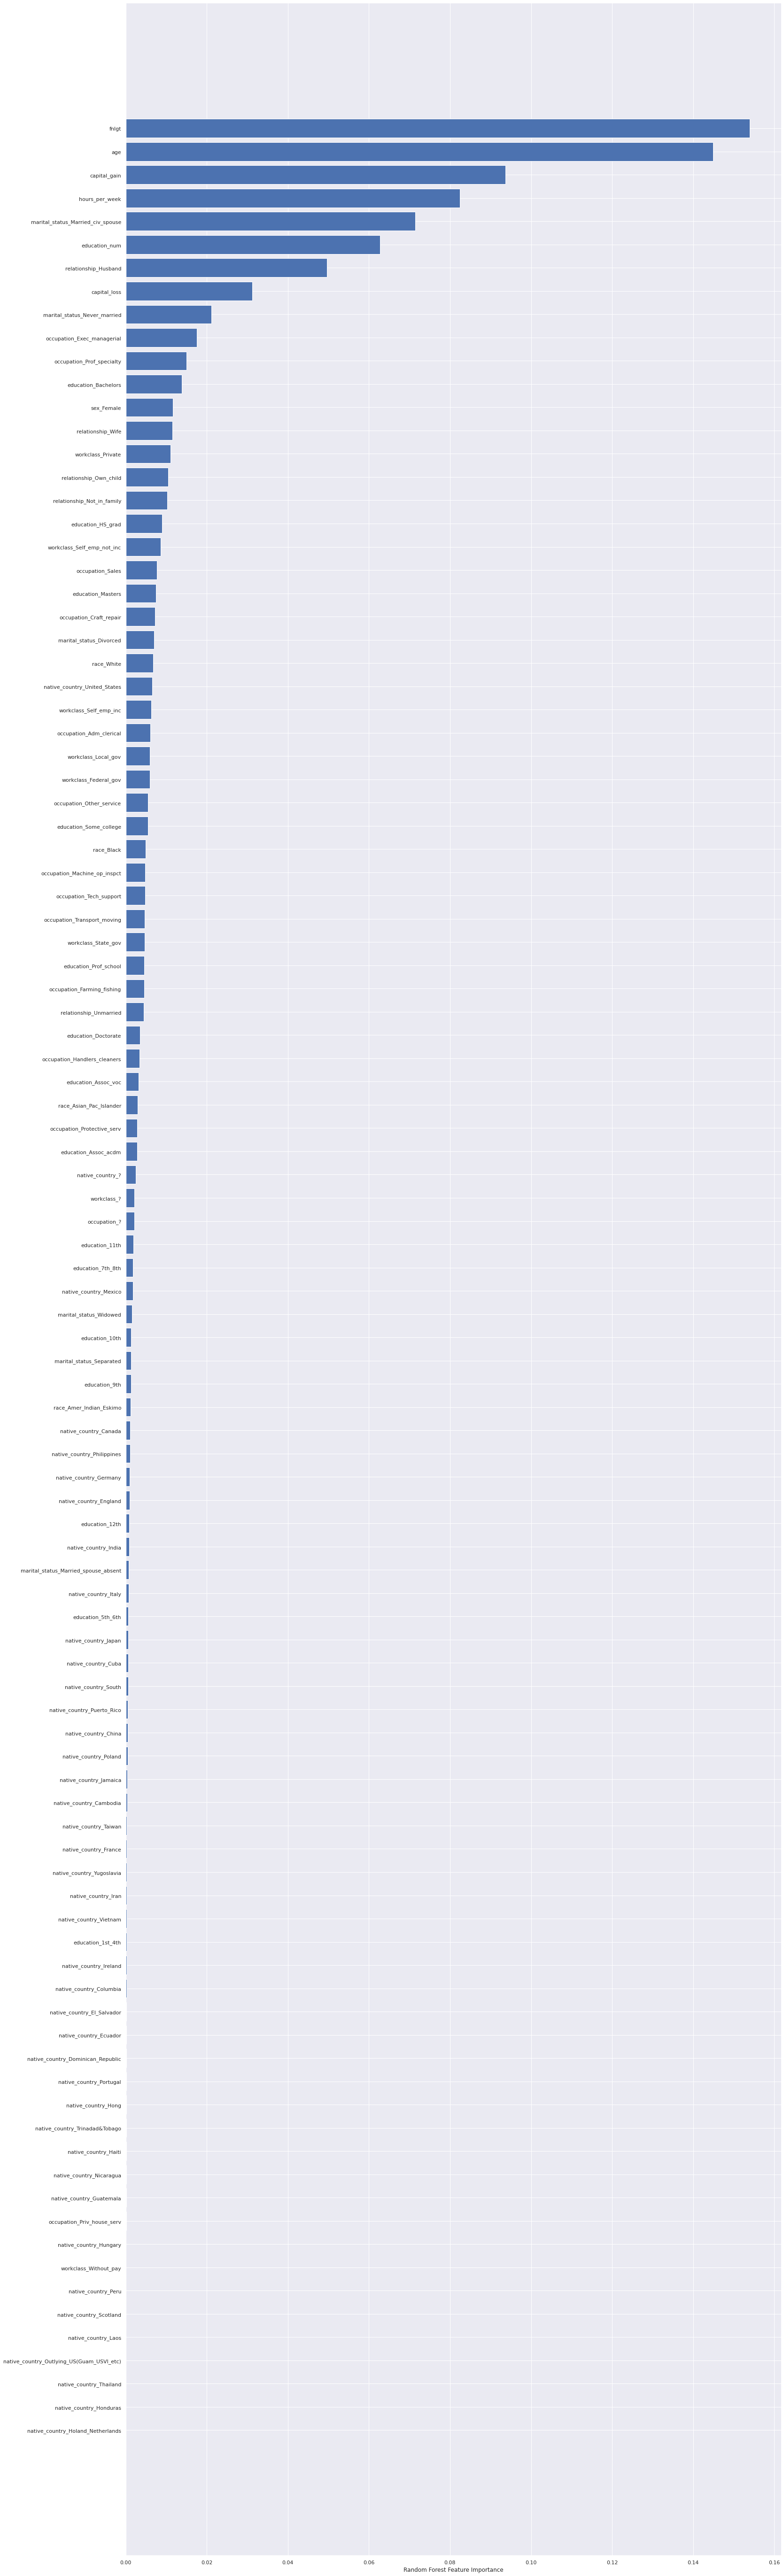

In [105]:
sorted_idx = rfc.feature_importances_.argsort()
fig = plt.figure(figsize=(25, 100))
plt.barh(X_train.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [111]:
# I will select onnly the first eight features, just for the sake of making the model simpler 

features = ['fnlgt',
'age',
'capital_gain',
'hours_per_week', 
'marital_status_Married_civ_spouse',
'education_num',
'relationship_Husband',
'capital_loss']

In [112]:
X_train[features]

fnlgt  age  capital_gain  hours_per_week  \
0       56460   34             0              12   
1      243631   48          7688              40   
2       56402   23             0              30   
3      255406   56             0              40   
4      297246   17             0               9   
...       ...  ...           ...             ...   
22787  359461   47             0              40   
22788  147215   31             0              21   
22789  216284   18             0              20   
22790   54261   50             0              84   
22791  127651   34             0              60   

       marital_status_Married_civ_spouse  education_num  relationship_Husband  \
0                                      1              9                     0   
1                                      1             10                     1   
2                                      1             10                     1   
3                                      0              9                     0   
4                                      0              7                     0   
...                                  ...            ...                   ...   
22787                                  1             13                     1   
22788                                  0              8                     0   
22789                                  0              7                     0   
22790                                  1              9                     1   
22791                                  0             13                     0   

       capital_loss  
0              2179  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
22787             0  
22788             0  
22789             0  
22790             0  
22791             0  

[22792 rows x 8 columns]

In [113]:
# grid search
rfc = RandomForestClassifier(random_state=42)
# Use a different solver if the default 'lbfgs' fails to converge
# Reference: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

lrc = LogisticRegression(solver='lbfgs', max_iter=3000)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,100],
    'criterion' :['gini', 'entropy']
}

cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
cv_rfc.fit(X_train[features], y_train)

lrc.fit(X_train_final[features], y_train)

y_train_preds_rf = cv_rfc.best_estimator_.predict(X_train[features])
y_test_preds_rf = cv_rfc.best_estimator_.predict(X_test[features])

y_train_preds_lr = lrc.predict(X_train_final[features])
y_test_preds_lr = lrc.predict(X_test_final[features])

# scores
print('random forest results')
print('test results')
print(classification_report(y_test, y_test_preds_rf))
print('train results')
print(classification_report(y_train, y_train_preds_rf))

print('logistic regression results')
print('test results')
print(classification_report(y_test, y_test_preds_lr))
print('train results')
print(classification_report(y_train, y_train_preds_lr))

random forest results
test results
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      7455
           1       0.80      0.50      0.61      2314

    accuracy                           0.85      9769
   macro avg       0.83      0.73      0.76      9769
weighted avg       0.85      0.85      0.84      9769

train results
              precision    recall  f1-score   support

           0       0.86      0.96      0.91     17265
           1       0.81      0.52      0.63      5527

    accuracy                           0.85     22792
   macro avg       0.83      0.74      0.77     22792
weighted avg       0.85      0.85      0.84     22792

logistic regression results
test results
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      7455
           1       0.71      0.55      0.62      2314

    accuracy                           0.84      9769
   macro avg       0.79      0.74     

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


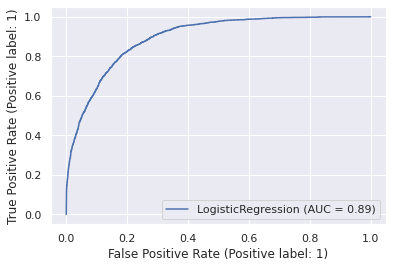

In [114]:
lrc_plot = plot_roc_curve(lrc, X_test_final[features], y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


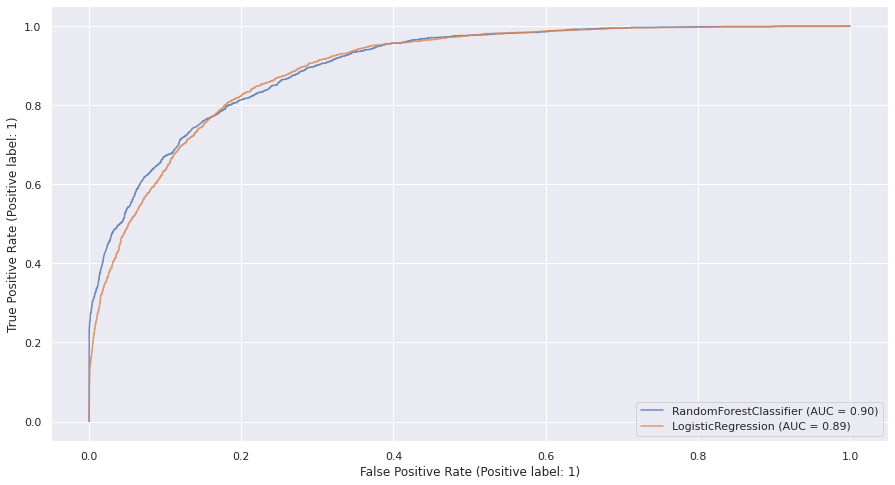

In [115]:
# plots
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(cv_rfc.best_estimator_, X_test[features], y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

In [116]:
# save best model
joblib.dump(cv_rfc.best_estimator_,'rfc_model.pkl')
joblib.dump(lrc,'logistic_model.pkl')

['logistic_model.pkl']